In [ ]:
!pip install numpy pandas yfinance matplotlib tensorflow keras

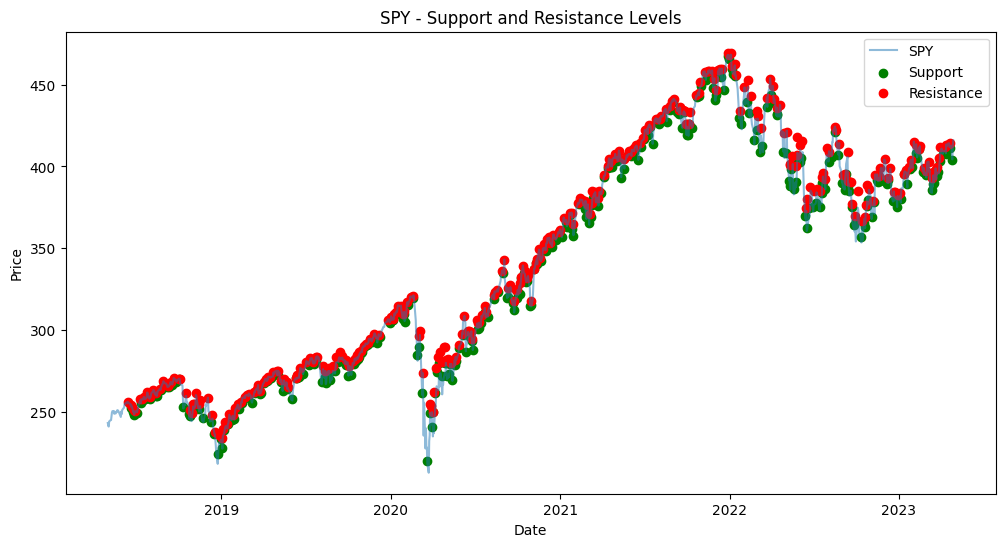

In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

ticker = 'SPY'
data = yf.download(ticker, start='2018-05-01', end='2023-05-01')

data['returns'] = data['Adj Close'].pct_change().fillna(0)

def create_agent():
    model = Sequential()
    model.add(Dense(units=32, activation='relu', input_dim=30))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

window_size = 30
epochs = 10

agent = create_agent()

for epoch in range(epochs):
    for i in range(window_size, len(data) - 1):
        X = data['returns'][i-window_size:i].values.reshape(1, -1)
        y = data['returns'][i+1].reshape(1, -1) 
        agent.train_on_batch(X, y)

predicted_returns = []

for i in range(window_size, len(data)):
    X = data['returns'][i-window_size:i].values.reshape(1, -1)
    prediction = agent.predict(X)
    predicted_returns.append(prediction[0][0])

data['predicted_returns'] = np.nan
data['predicted_returns'][window_size:] = predicted_returns
data['predicted_price'] = data['Adj Close'] * (1 + data['predicted_returns'])

def local_minima(arr):
    return argrelextrema(arr, np.less)

def local_maxima(arr):
    return argrelextrema(arr, np.greater)

minima_indices = local_minima(data['predicted_price'].values)
maxima_indices = local_maxima(data['predicted_price'].values)

support_levels = data['predicted_price'].iloc[minima_indices[0]]
resistance_levels = data['predicted_price'].iloc[maxima_indices[0]]

plt.figure(figsize=(12, 6))
plt.plot(data['Adj Close'], label='SPY', alpha=0.5)
plt.scatter(data.index[minima_indices], support_levels, color='g', marker='o', label='Support')
plt.scatter(data.index[maxima_indices], resistance_levels, color='r', marker='o', label='Resistance')
plt.title('SPY - Support and Resistance Levels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()